# Optimizer Example
Jena Climate RNN example showing comparison between Adam and other optimizers available when it was introduced.
This is a regression model, using 3-hour data.

Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

|Dataset|Architecture|Group|Type|
|---|---|---|---|
|Jena 3hr|RNN|Contemporary|Regression|

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]
xTrain = np.expand_dims(xTrain, -1) 

CPU times: total: 2.53 s
Wall time: 3.36 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model functions
#def model_core():
#    model = tf.keras.Sequential(
#        [
#            tf.keras.Input(shape=(blk_len,col_len)),
#            fixMe,
#            tf.keras.layers.LSTM(64),
#            tf.keras.layers.Dropout(0.2),
#            tf.keras.layers.Dense(1,
#                                  activation='linear')
#        ]
#    )
#    return model
def model_core():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len,1)),
            fixMe,
            tf.keras.layers.Conv2D(64, 
                                   kernel_size=(3, 7),
                                   strides=(1,3),
                                   padding='same',
                                   activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#            tf.keras.layers.Conv2D(64, 
#                                   kernel_size=(3, 3),
#                                   padding='same',
#                                   activation="relu"),
#            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, 
                                  activation="linear")
        ]
    )
    return model    
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model=model_core()
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    # Reduce variation in training...
    tf.random.set_seed(17)
    print("History Match:")
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    print("\n")
    print("Evaluate Model:")
    myEva=model.evaluate(xTrain,
                         y_train,
                         batch_size=bat_len)
    print("All Sample MSE:",myEva[0])
    print("All Sample MAE:",myEva[1])
    print("\n")
    print("Make Predictions:")
    myPre=model.predict(xTrain)
    print("\n")
    print("Timing:")
    return myHis,myPre

In [12]:
m=model_core()
m.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11, 1)          │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 4, 64)          │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,604 (37.52 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 3 (16.00 B)

### First Model, Adam

In [13]:
%%time
h0,p0=model_build('adam')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 94.8971 - mean_absolute_error: 7.8659 - val_loss: 67.5668 - val_mean_absolute_error: 6.7340
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 70.2756 - mean_absolute_error: 6.8538 - val_loss: 69.6578 - val_mean_absolute_error: 6.8083
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 70.0699 - mean_absolute_error: 6.8460 - val_loss: 69.2699 - val_mean_absolute_error: 6.7916
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 69.9044 - mean_absolute_error: 6.8392 - val_loss: 68.7680 - val_mean_absolute_error: 6.7699
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 69.7297 - mean_absolute_error: 6.8294 - val_loss: 68.9257 - val_mean_absolute_error: 6.7720
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 69.4395 - mean_absolute_error: 6.8154 - val_loss: 69.3426 - val_mean_absolute_error: 6.7827
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 69.1535 - mean_absol

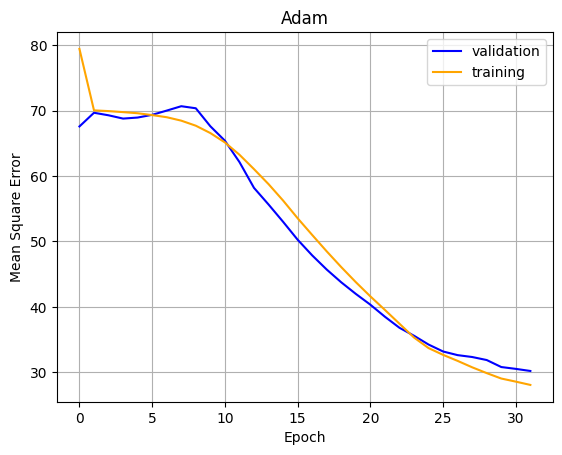

In [14]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

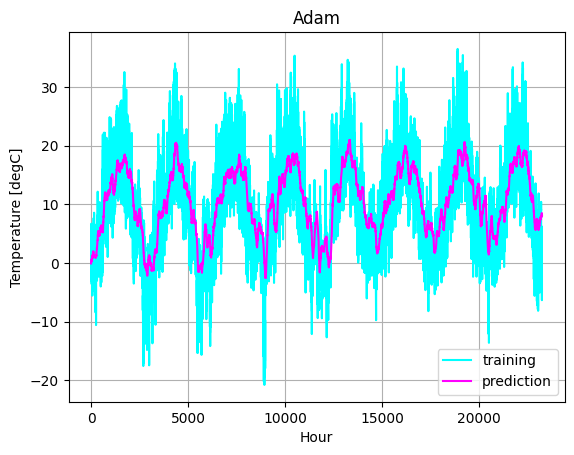

In [15]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam')
plt.grid()
plt.show()

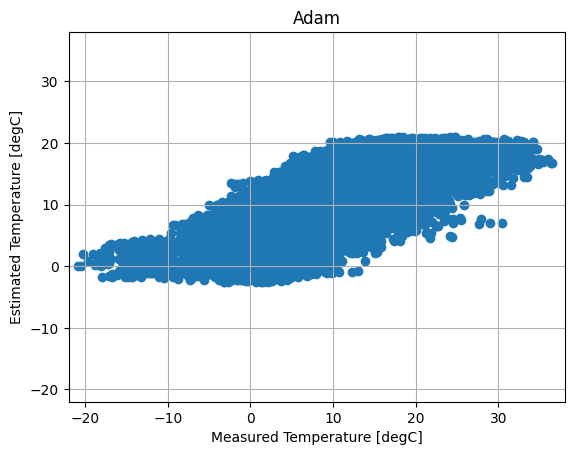

In [16]:
plt.scatter(y_train,p0.flatten(),marker='o')
plt.ylabel('Estimated Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.xlim([-22,38])
plt.ylim([-22,38])
plt.show()

### Second Model, AdaGrad

In [17]:
%%time
h1,p1=model_build('adagrad')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 102.3926 - mean_absolute_error: 8.1869 - val_loss: 70.6829 - val_mean_absolute_error: 6.8511
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 70.2086 - mean_absolute_error: 6.8593 - val_loss: 70.2953 - val_mean_absolute_error: 6.8361
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 70.2100 - mean_absolute_error: 6.8585 - val_loss: 70.3036 - val_mean_absolute_error: 6.8362
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 70.1745 - mean_absolute_error: 6.8577 - val_loss: 70.3159 - val_mean_absolute_error: 6.8364
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 70.1798 - mean_absolute_error: 6.8566 - val_loss: 70.2969 - val_mean_absolute_error: 6.8354
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 70.1484 - mean_absolute_error: 6.8533 - val_loss: 70.2985 - val_mean_absolute_error: 6.8352
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 70.1268 - mean_abso

### Third Model, Stochastic Gradient Descent with Nesterov Momentum

In [18]:
opt012=tf.keras.optimizers.SGD(momentum=0.5,
                               nesterov=True,
                               name='nSGD'
                              )

In [19]:
%%time
h2,p2=model_build(opt012)

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 8/32
37/37 ━━━━━━━━━

### Fourth Model, Root Mean Squared Propagation

In [20]:
%%time
h3,p3=model_build('rmsprop')

History Match:
Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 84.7966 - mean_absolute_error: 7.4663 - val_loss: 66.5793 - val_mean_absolute_error: 6.7278
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 71.2276 - mean_absolute_error: 6.8905 - val_loss: 66.3679 - val_mean_absolute_error: 6.7154
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 71.0232 - mean_absolute_error: 6.8819 - val_loss: 66.0687 - val_mean_absolute_error: 6.6979
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 70.7108 - mean_absolute_error: 6.8662 - val_loss: 65.8551 - val_mean_absolute_error: 6.6852
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 70.3862 - mean_absolute_error: 6.8514 - val_loss: 65.5847 - val_mean_absolute_error: 6.6694
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 70.0497 - mean_absolute_error: 6.8315 - val_loss: 65.3145 - val_mean_absolute_error: 6.6537
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 69.6822 - mean_absol

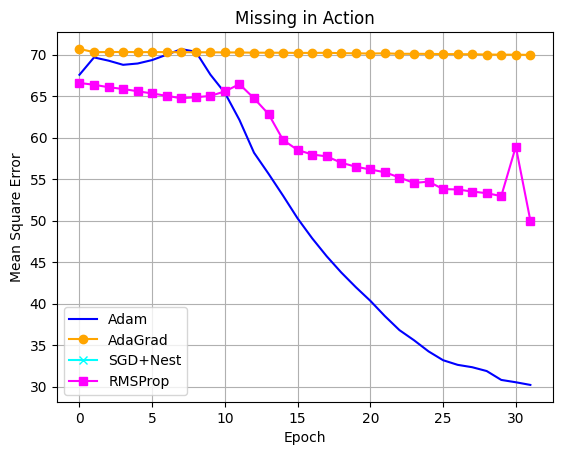

In [21]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSProp'])
plt.title('Missing in Action')
plt.grid()
plt.show()

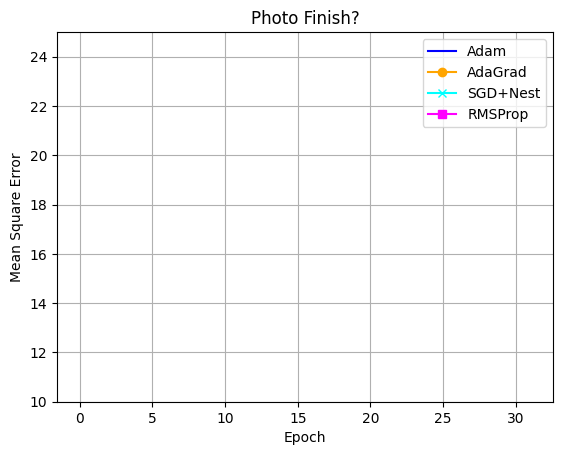

In [22]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSProp'])
plt.title('Photo Finish?')
plt.ylim([10,25])
plt.grid()
plt.show()

### Model Summary

In [23]:
m=model_core()
m.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 128, 11, 1)          │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 4, 64)          │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 2, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,604 (37.52 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 3 (16.00 B)